In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

# Final best solution

In [5]:
'''
    We have two solutions:
    1- range_segmentation
        Segments the image using a specified range.
    2- cr or cb
        Segment using cr || cb components.

    Both solutions are good but "cr or cb give better solution in general",
    but in some cases it fails and in this cases range_segmentation give better solution,
    so, we combined the two solutions together,
    simply modifed (cr || cb) to be ((cr || cb) && range_segmentation).
'''

def range_segmentation(ycrcb_image):
    '''
        The `range_segmentation` function takes an input image in YCrCb color space
        1- Segments the image based on the lower and upper bounds of skin color defined in YCrCb color space.
        2- It applies morphological operations to remove noise,
        3- Finds the contours in the binary segmented image, gets the contour with the largest area,
        4- Creates a blank image to draw and fill the contours,
        5- Draws the largest contour on the blank image and fills the contour with white color,
        6- Returns the image with the largest contour drawn on it.
    '''
    ##################################################################
    # Segment the image based on the lower and upper bounds of skin color defined in YCrCb color space.

    # Define the lower and upper bounds of the skin color in YCrCb color space
    lower_skin = np.array([0, 130, 75])
    upper_skin = np.array([255, 180, 150])
    # Apply the color segmentation using cv2.inRange() (Segment only the image in the lower and upper range)
    binary_ycrcb_image = cv.inRange(ycrcb_image, lower_skin, upper_skin)
    ##################################################################

    ##################################################################
    # Apply morphological operations to remove noise
    # Erode the image with kernel 20x20 with only 1 iteration
    kernel = np.ones((20, 20), np.uint8)
    img_erode = cv.erode(binary_ycrcb_image, kernel, iterations=1)
    # Dilate the image with kernel 20x20 with only 1 iteration
    kernel = np.ones((20, 20), np.uint8)
    img_dilate = cv.dilate(img_erode, kernel, iterations=1)
    ##################################################################

    ##################################################################
    #finds the contours in the binary segmented image, gets the contour with the largest area
    # Find the contours in the binary segmented image
    contours, hierarchy = cv.findContours(
        img_dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Get the contour with the largest area
    largest_contour = max(contours, key=cv.contourArea)

    # Create a blank image to draw and fill the contours
    largest_contour_image_ycrcb = np.zeros_like(img_dilate)

    # Draw the largest contour on the blank image and fill the contour with white color(255,255)
    cv.drawContours(largest_contour_image_ycrcb, [
                    largest_contour], 0, (255, 255), -1)
    ##################################################################

    # Return the image with the largest contour drawn on it
    return largest_contour_image_ycrcb


def preprocess(img):
    '''
        1- Convert the input image to YCrCb color space.
        2- Get the segmented using 'range_segmentation' method.
        3- Extract the individual color components.
        4- Apply thresholding on cr and cb components.
        5- (cr || cb) && range_segmented_image.
        6- Apply morphological operations to remove noise.
        7- Get the contour with the largest area.
        8- Segment the image in grey scale.
        9- Cut the greyscale image around the largest contour.
        10- Resize all the images to one size to get same features vector size
    '''

    ##################################################################
    # Convert the input image to YCrCb color space
    ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    ##################################################################

    ##################################################################
    # Get the segmented using 'range_segmentation' method
    range_segmented_image = range_segmentation(ycrcb_image)
    ##################################################################

    ##################################################################
    # Extract the individual color components (Split the ycrcb image to its components y,cr,cb)
    y, cr, cb = cv.split(ycrcb_image)
    ##################################################################

    ##################################################################
    # Apply thresholding on cr and cb components
    _, cr = cv.threshold(cr, 0, 255, cv.THRESH_OTSU)
    _, cb = cv.threshold(cb, 0, 255, cv.THRESH_OTSU)
    # Invert the cb component because the skin is black and background is white in cb
    cb = 255 - cb
    ##################################################################

    ##################################################################
    # cr_or_cb = (cr || cr) && range_segmented_image
    # this solution depends only on (cr || cb) but we combined the solution using range_segmented_image to enhance this solution
    cr_or_cb = cv.bitwise_and(cv.bitwise_or(cr, cb), range_segmented_image)
    ##################################################################

    ##################################################################
    # Apply morphological operations to remove noise
    # Erode the image with kernel 10x10 with 2 iteration
    kernel = np.ones((10, 10), np.uint8)
    img_erode = cv.erode(cr_or_cb, kernel, iterations=2)
    # Dilate the image with kernel 20x20 with 4 iteration
    kernel = np.ones((20, 20), np.uint8)
    img_dilate = cv.dilate(img_erode, kernel, iterations=4)
    ##################################################################

    ##################################################################
    # Get all contours
    contours, hierarchy = cv.findContours(
        img_dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Get the contour with the largest area
    # Note: it is a 3d list of coordinates of the shape that contains the contour
    largest_contour = max(contours, key=cv.contourArea)

    # Get boundaries of the largest contour to cut grey scale image with them
    min_x_coord = np.min(largest_contour[:, :, 0])
    max_x_coord = np.max(largest_contour[:, :, 0])
    min_y_coord = np.min(largest_contour[:, :, 1])
    max_y_coord = np.max(largest_contour[:, :, 1])

    # Create a blank image to draw and fill the contours
    largest_contour_image = np.zeros_like(img_dilate)

    # Draw the largest contour on the blank image and fill the contour with white color(255,255)
    cv.drawContours(largest_contour_image, [largest_contour], 0, (255, 255), -1)
    ##################################################################

    ##################################################################
    # Segment the image in grey scale
    # Segment the grey scale image using the binary image
    grey_scale_res = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    grey_scale_res[largest_contour_image == 0] = 0

    # Apply histogram equaliztion to make the image more clear (May be not needed)
    grey_scale_res = cv.equalizeHist(grey_scale_res)
    ##################################################################
    grey_scale_res = grey_scale_res[min_y_coord:max_y_coord, min_x_coord:max_x_coord]
    
    ##################################################################
    # Resize all the images to one size to get same features vector size
    wanted_size = (3900, 1900)
    final_res = cv.resize(grey_scale_res, wanted_size)
    ##################################################################

    return final_res

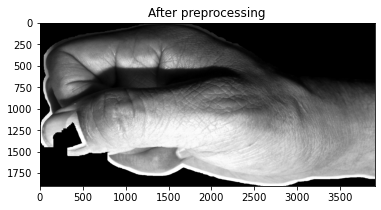

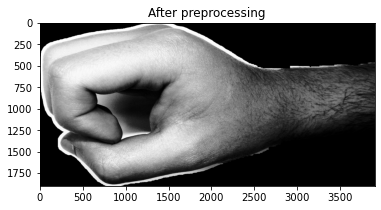

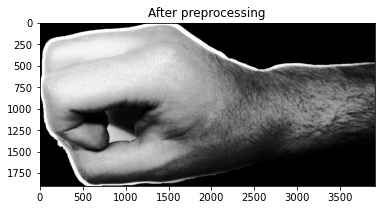

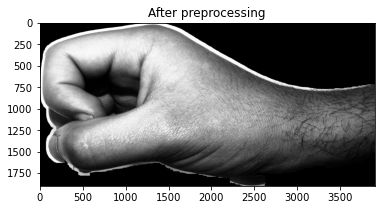

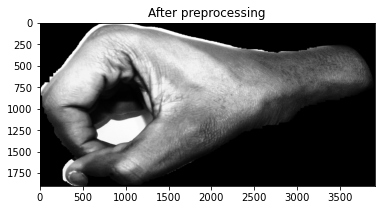

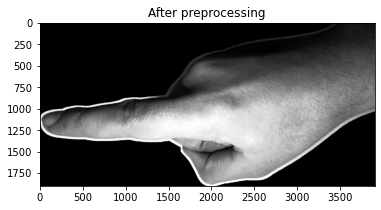

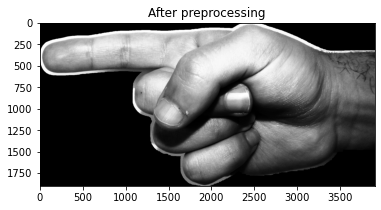

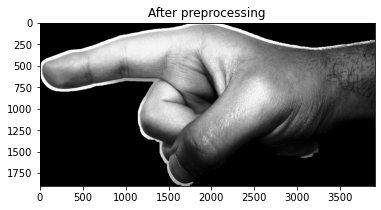

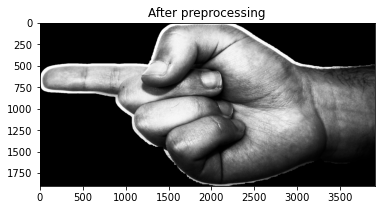

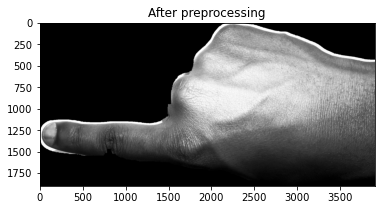

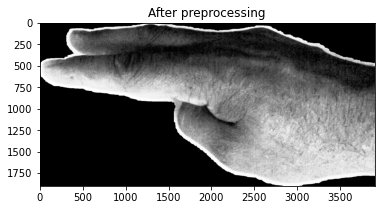

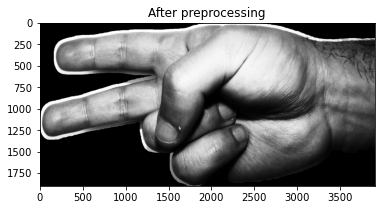

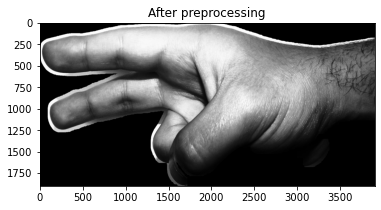

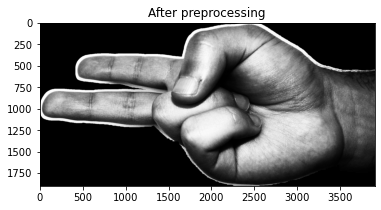

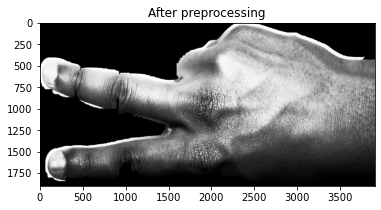

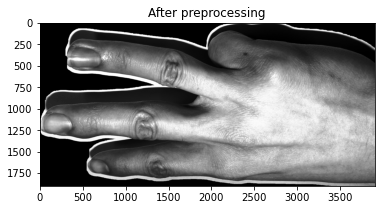

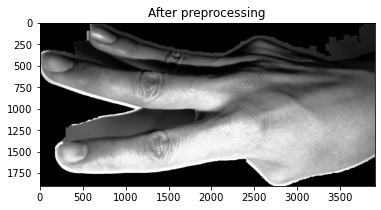

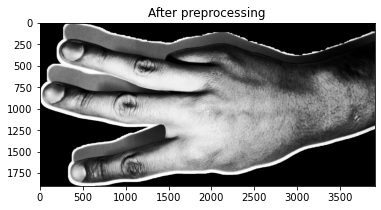

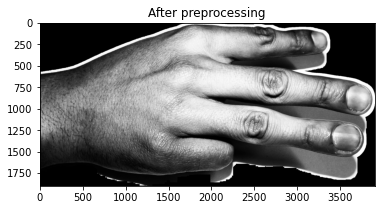

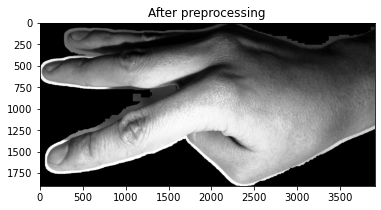

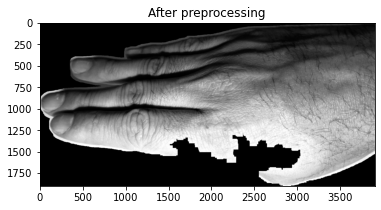

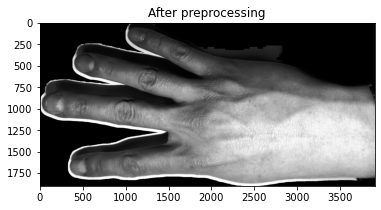

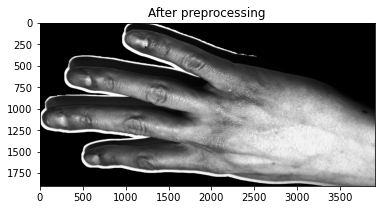

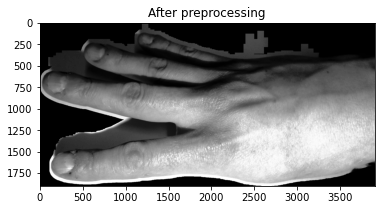

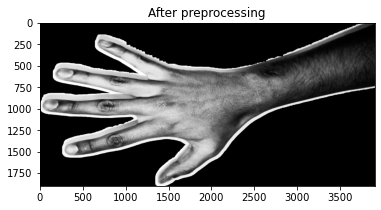

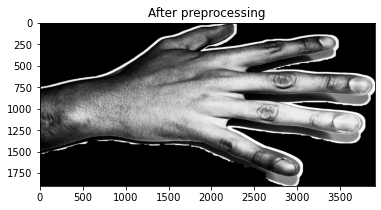

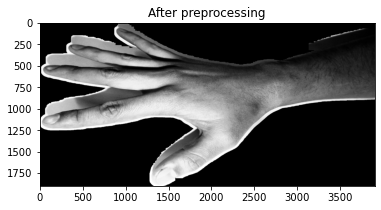

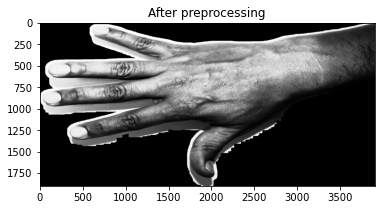

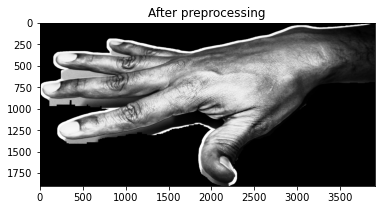

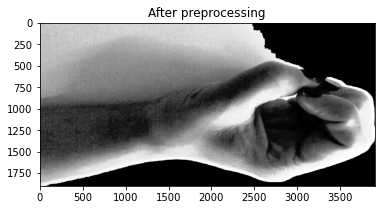

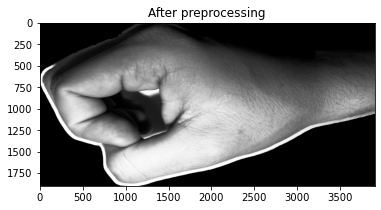

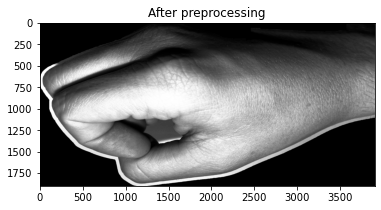

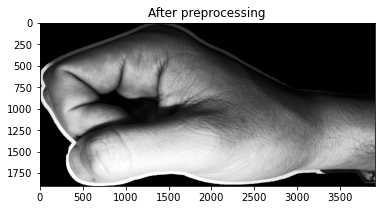

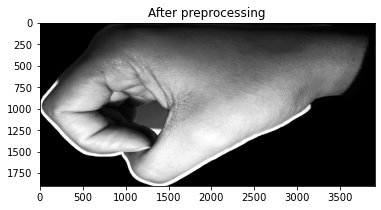

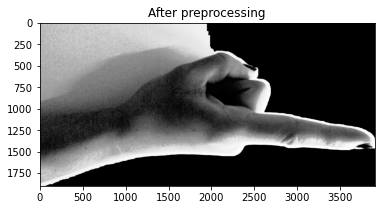

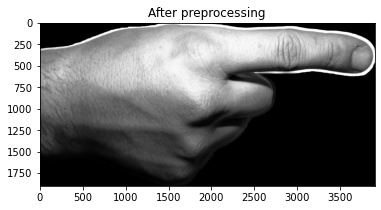

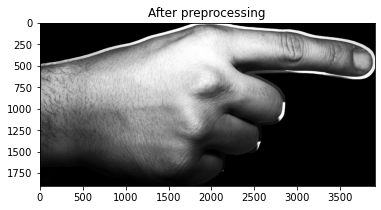

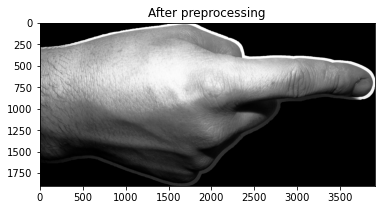

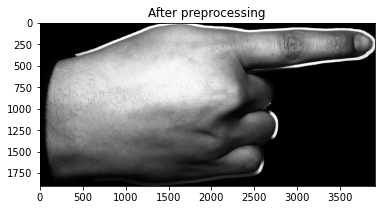

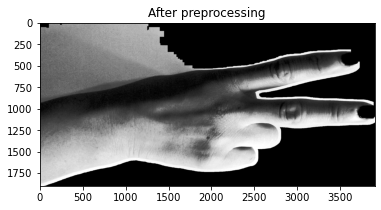

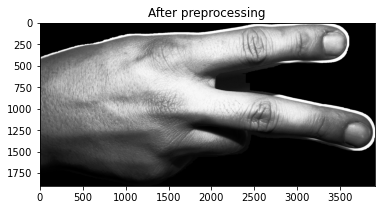

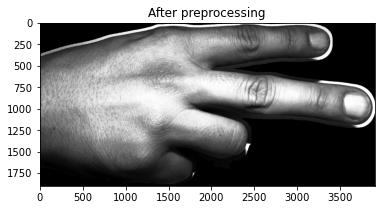

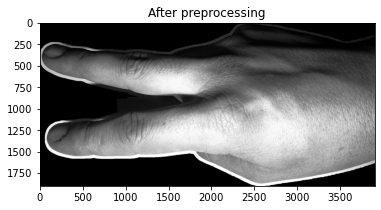

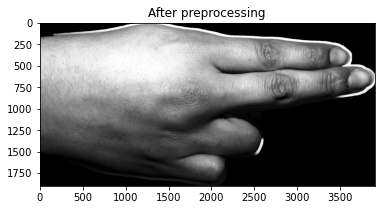

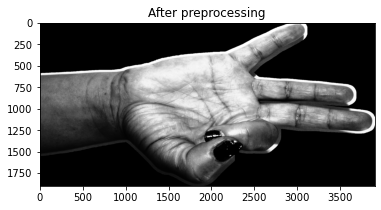

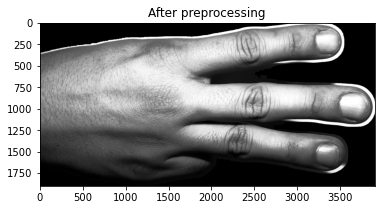

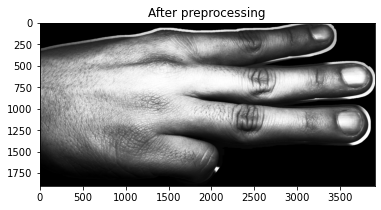

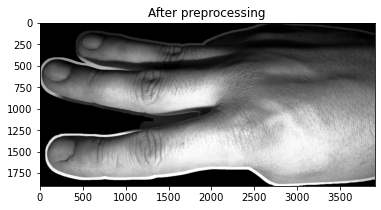

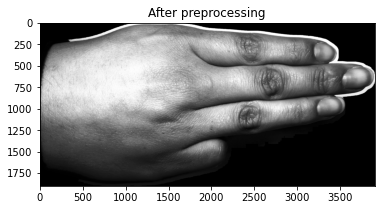

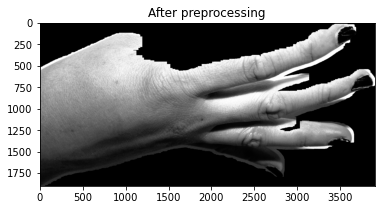

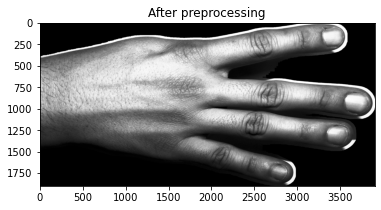

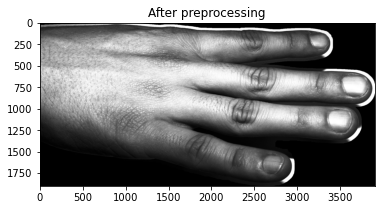

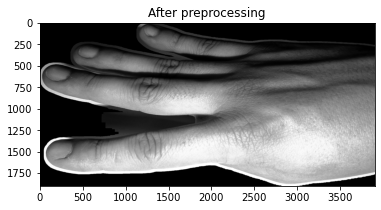

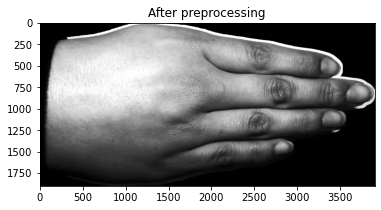

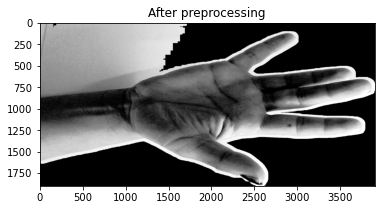

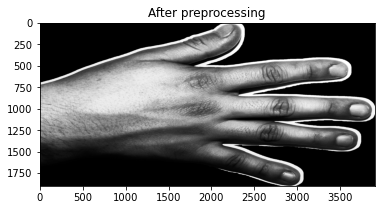

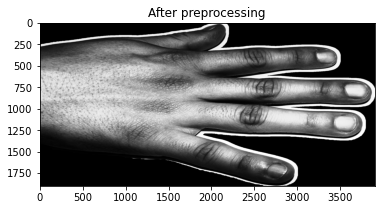

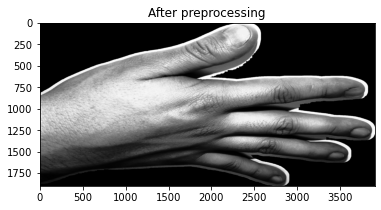

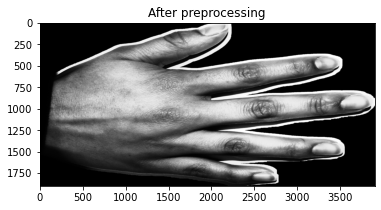

In [6]:
# Trying with dataset sample

for i in range(6):
    for j in os.listdir("./../../dataset_sample/men/" + str(i)):
        if j.endswith(".ini"):
            continue
        img = cv.imread("./../../dataset_sample/men/" + str(i) + "/" + j)
        segmented_greyscale = preprocess(img)
        show_images([segmented_greyscale], ["After preprocessing"])


for i in range(6):
    for j in os.listdir("./../../dataset_sample/Women/" + str(i)):
        if j.endswith(".ini"):
            continue
        img = cv.imread("./../../dataset_sample/Women/" + str(i) + "/" + j)
        segmented_greyscale = preprocess(img)
        show_images([segmented_greyscale], ["After preprocessing"])